In [1]:
# default_exp tile_clustering

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tile Clustering

> cluster together adjacent grid tiles

In [4]:
from collections import deque
from typing import List, Optional, Tuple

# exporti
import pandas as pd
from fastcore.basics import patch

In [5]:
# export


class TileClustering:
    """
    Cluster together adjacent square grid cells. Grid cells belonging to the same cluster will get
    assigned the same ID. Optionally, you cluster adjacent cells by category by passing in `category_col`

    By default, with cluster_type = " four-way", it clusters together grid cells with adjacent edges only.
    If you wish to consider grid cells with adjacent corners as well, use cluster_type = " eight-way"
    """

    def __init__(
        self,
        cluster_type: str = "four_way",
    ) -> None:

        assert cluster_type in ["four_way", "eight_way"]
        self.cluster_type = cluster_type
        self.tile_cluster_col = "tile_cluster"

In [6]:
# export


@patch
def cluster_tiles(
    self: TileClustering,
    df: pd.DataFrame,
    grid_x_col="x",
    grid_y_col="y",
    category_col: Optional[str] = None,
) -> pd.DataFrame:
    """
    Appends the cluster ID for each square grid cell
    """

    if category_col is None:
        cluster_df = self._cluster_tiles_single(df, grid_x_col, grid_y_col)
    else:
        assert (
            not df[category_col].isnull().any()
        ), f"There shouldn't be null values for {category_col}"
        unique_categories = df[category_col].unique().tolist()

        cluster_df_list = []
        for i, category in enumerate(unique_categories, start=1):
            bool_mask = df[category_col] == category
            filtered_df = df.loc[bool_mask, :].copy()
            cluster_filtered_df = self._cluster_tiles_single(
                filtered_df, grid_x_col, grid_y_col
            )
            cluster_filtered_df[self.tile_cluster_col] = cluster_filtered_df[
                self.tile_cluster_col
            ].apply(lambda key: f"{key}-{i}")
            cluster_df_list.append(cluster_filtered_df)
        cluster_df = pd.concat(cluster_df_list, axis=0, ignore_index=True)

    df = pd.merge(left=df, right=cluster_df, on=[grid_x_col, grid_y_col], how="left")

    return df

In [7]:
# exporti


@patch
def _cluster_tiles_single(
    self: TileClustering,
    df: pd.DataFrame,
    grid_x_col="x",
    grid_y_col="y",
) -> pd.DataFrame:
    """
    Performs tile clustering on a single category
    """

    if self.tile_cluster_col in df.columns:
        raise ValueError(
            f"{self.tile_cluster_col} already exists as a column. Please rename"
        )

    grid_x = df[grid_x_col]
    grid_y = df[grid_y_col]

    self.grid_idx = set(zip(grid_x, grid_y))

    self.tile_cluster_dict = {}
    self.cluster_id = 0

    for key in self.grid_idx:
        if key not in self.tile_cluster_dict.keys():
            self.cluster_id += 1

            # reset the call stack per iteration
            self.call_stack = deque()
            self._dfs_connected_components(key)

    cluster_df = pd.DataFrame.from_dict(
        self.tile_cluster_dict, orient="index", columns=[self.tile_cluster_col]
    )
    cluster_df = cluster_df.reset_index()
    cluster_df[grid_x_col] = cluster_df["index"].apply(lambda idx: idx[0])
    cluster_df[grid_y_col] = cluster_df["index"].apply(lambda idx: idx[1])
    cluster_df = cluster_df.drop(columns="index")

    return cluster_df


@patch
def _get_adjacent_keys(
    self: TileClustering,
    key: Tuple[int, int],
) -> List[Tuple[int, int]]:

    x_idx = key[0]
    y_idx = key[1]

    east_key = (x_idx + 1, y_idx)
    west_key = (x_idx - 1, y_idx)
    south_key = (x_idx, y_idx - 1)
    north_key = (x_idx, y_idx + 1)

    if self.cluster_type == "four_way":
        adjacent_keys = [east_key, west_key, south_key, north_key]

    if self.cluster_type == "eight_way":
        northeast_key = (x_idx + 1, y_idx + 1)
        northwest_key = (x_idx - 1, y_idx + 1)
        southeast_key = (x_idx + 1, y_idx - 1)
        southwest_key = (x_idx - 1, y_idx - 1)

        adjacent_keys = [
            east_key,
            west_key,
            south_key,
            north_key,
            northeast_key,
            northwest_key,
            southeast_key,
            southwest_key,
        ]

    return adjacent_keys


@patch
def _dfs_connected_components(
    self: TileClustering,
    key: Tuple[int, int],
) -> None:
    """
    A non-recursive depth-first search implementation of connected components
    """
    self.call_stack.append(key)
    while self.call_stack:
        ref_key = self.call_stack.pop()

        # check if key exists in the first place
        if ref_key in self.grid_idx:
            # check if adjacent key has already been assigned
            if ref_key not in self.tile_cluster_dict.keys():
                self.tile_cluster_dict[ref_key] = self.cluster_id

                adjacent_keys = self._get_adjacent_keys(ref_key)
                for adjacent_key in adjacent_keys:
                    self.call_stack.append(adjacent_key)

## Test data

Create sample scores for square grid cells and cluster the cells

In [8]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

In [9]:
import geopandas as gpd
import numpy as np

from geowrangler import grids

np.random.seed(1562)

region3_gdf = gpd.read_file("../data/region3_admin.geojson")

In [10]:
grid_generator5k = grids.SquareGridGenerator(5_000)
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)
grid_gdf5k.head()

,x,y,geometry
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755..."
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755..."
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755..."
3,9,9,"POLYGON ((120.19008 14.79871, 120.23499 14.798..."
4,10,9,"POLYGON ((120.23499 14.79871, 120.27991 14.798..."


<AxesSubplot:>

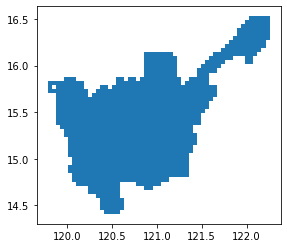

In [11]:
grid_gdf5k.plot()

In [12]:
%%time

grid_gdf5k["score"] = np.random.random(len(grid_gdf5k))
grid_gdf5k["class"] = grid_gdf5k["score"] > 0.7
grid_gdf5k.head()

CPU times: user 3.15 ms, sys: 1.32 ms, total: 4.47 ms
Wall time: 10 ms


,x,y,geometry,score,class
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755...",0.761806,True
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755...",0.012455,False
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755...",0.446552,False
3,9,9,"POLYGON ((120.19008 14.79871, 120.23499 14.798...",0.669020,False
4,10,9,"POLYGON ((120.23499 14.79871, 120.27991 14.798...",0.815914,True


In [13]:
%%time
tileclustering = TileClustering()
grid_gdf5k = tileclustering.cluster_tiles(grid_gdf5k, category_col="class")
grid_gdf5k.head()

CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 47.6 ms


,x,y,geometry,score,class,tile_cluster
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755...",0.761806,True,6-1
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755...",0.012455,False,7-2
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755...",0.446552,False,1-2
3,9,9,"POLYGON ((120.19008 14.79871, 120.23499 14.798...",0.669020,False,1-2
4,10,9,"POLYGON ((120.23499 14.79871, 120.27991 14.798...",0.815914,True,23-1


In [14]:
grid_gdf5k["tile_cluster"].nunique()

160

<AxesSubplot:>

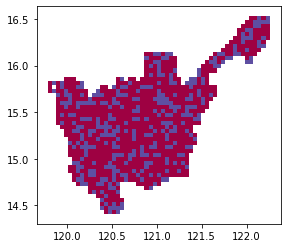

In [15]:
grid_gdf5k.plot(column="class", categorical=True, cmap="Spectral")